###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c) 2019 Daniel Koehn, based on (c)2018 L.A. Barba, G.F. Forsyth [CFD Python](https://github.com/barbagroup/CFDPython#cfd-python), (c)2014 L.A. Barba, I. Hawke, B. Knaepen [Practical Numerical Methods with Python](https://github.com/numerical-mooc/numerical-mooc#practical-numerical-methods-with-python), also under CC-BY.

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# 2D Linear Advection Equation

In order to solve the 2D thermal mantle convection in the next class, we first have to deal with the 2D advection problem. To mitigate the effect of numerical diffusion, we solve the problem by implementing a 2D Marker-in-Cell code based on our 1D implementation from [this notebook](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/04_Advection_1D/03_Numerical_Diffusion.ipynb).

## 2D Linear Advection Problem

The linear 2D heat advection equation reads:

\begin{equation}
\frac{\partial T}{\partial t} + v_x \frac{\partial T}{\partial x} + v_z \frac{\partial T}{\partial z}= 0, \tag{1}
\end{equation}

where $T$ denotes the 2D temperature field and $v_x, v_z$ the components of the velocity field in x- and z-direction, respectively.

As we have discussed in [this exercise](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/04_Advection_1D/03_Numerical_Diffusion.ipynb) almost all finite-difference based approaches to solve the advection problem suffer either from numerical instability or numerical diffusion. Therefore, we used the **Marker-in-Cell method** to avoid these problems. The basic 1D Marker-in-Cell code can be reused for the 2D advection problem. However, we have to consider some problems and improvements in our 2D Marker-in-Cell code:

For each marker $i$ at position $x_i$ and time $t^n$:

1. Save the current marker position $x^n,\; z^n$ at time step $n$. 

2. Estimate velocity field ${\bf{V^n}} = (V_x^n,\;V_z^n)^T$ at current marker positions $x^n$ using linear interpolation.

3. Estimate temperature field $T$ at current marker positions using cubic interpolation.

4. Update marker positions via $x^{n+1} = x^n + dt\; v(t^{n+1},x^n)$

5. Estimate new velocity field ${\bf{V^{n+1}}} = (V_x^{n+1},\;V_z^{n+1})^T$ at marker positions $x^{n+1}$ using linear interpolation.

6. Estimate an average velocity $\bf{V_{avg}} = \frac{{\bf{V^{n+1}}}+{\bf{V^{n}}}}{2}$

7. Starting again from point $x^n$ and update the marker position via $x^{n+1} = x^n + dt\; V_{avg}$

5. Use cubic interpolation to estimate the temperature on the 2D grid using the temperature of the markers.

Some care has to be taken if point $x^n$ is outside of the computational domain, since
Python will return NaN for the velocity (or temperature) of this point. If no extrapolation is desired, use the velocity $V(t^{n}, x_i)$ in this case.

Let 's implement this **midpoint scheme** in Python:

In [2]:
# Import libraries
import numpy
from matplotlib import pyplot
%matplotlib inline
from scipy import interpolate

In [3]:
# Set the font family and size to use for Matplotlib figures.
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [4]:
# Marker-in-cell code to solve the 2D advection equation
# ------------------------------------------------------
def Adv_2D(T0, nt, dt, dx, dz, Vx, Vz, Lx1, Lx2, Lz1, Lz2, x, z, X, Z):
    """
    Computes and returns the temperature distribution
    after a given number of time steps for the 2D advection 
    problem. A marker-in-cell approach with Dirichlet conditions 
    on all boundaries is used in order to mitigate the effect of 
    numerical diffusion.
    
    Parameters
    ----------
    T0 : numpy.ndarray
        The initial temperature distribution as a 2D array of floats.
    nt : integer
        Maximum number of time steps to compute.
    dt : float
        Time-step size.
    dx : float
        Grid spacing in the x direction.
    dz : float
        Grid spacing in the z direction.
    Vx : float
        x-component of the velocity field.
    Vz : float
        z-component of the velocity field.        
    Lx1, Lx2 : float
        Model extension from Lx1 - Lx2.
    Lz1, Lz2 : float
        Model extension from Lz1 - Lz2.
    x, z : float
        Model coordinates as 1D arrays.
    X, Z : float
        Model coordinates as 2D arrays.    
        
    
    Returns
    -------
    T : numpy.ndarray
        The temperature distribution as a 2D array of floats.
    """

    # Integrate in time.
    T = T0.copy()
    
    # Estimate number of grid points in x- and z-direction
    nz, nx = T.shape
    
    # Define number of markers and initial marker positions
    nx_mark = 4 * nx  # number of markers in x-direction
    nz_mark = 4 * nz  # number of markers in z-direction    
    
    # Time loop
    for n in range(nt):        
                
        # initial marker positions
        x_mark = numpy.linspace(Lx1, Lx2, num=nx_mark)
        z_mark = numpy.linspace(Lz1, Lz2, num=nz_mark)
        X_mark, Z_mark = numpy.meshgrid(x_mark,z_mark)
        
        # Interpolate velocities from grid to marker position at timestep n        
        f = interpolate.interp2d(x, z, Vx, kind='linear')
        vx_mark_n = f(x_mark, z_mark)
        
        f = interpolate.interp2d(x, z, Vz, kind='linear')
        vz_mark_n = f(x_mark, z_mark)
        
        # Interpolate temperature from grid to marker position at timestep n
        f = interpolate.interp2d(x, z, T, kind='cubic')
        T_mark = f(x_mark, z_mark)
        
        # Save current marker positions
        X0 = X_mark
        Z0 = Z_mark
        
        # Update marker position
        X_mark = X_mark + vx_mark_n * dt
        Z_mark = Z_mark + vz_mark_n * dt
        
        # Interpolate velocities from grid to marker position at timestep n+1 
        vx_mark_n1 = interpolate.griddata((X.flatten(), Z.flatten()), Vx.flatten(), (X_mark, Z_mark), method='linear')
        vz_mark_n1 = interpolate.griddata((X.flatten(), Z.flatten()), Vz.flatten(), (X_mark, Z_mark), method='linear')
        
        # Replace Nan values 
        mask = numpy.where(numpy.isnan(vx_mark_n1))
        vx_mark_n1[mask] = 0
        
        mask = numpy.where(numpy.isnan(vz_mark_n1))
        vz_mark_n1[mask] = 0
        
        # Update marker position with midpoint velocity
        X_mark = X0 + dt * (vx_mark_n + vx_mark_n1) / 2.
        Z_mark = Z0 + dt * (vz_mark_n + vz_mark_n1) / 2.

        # Interpolate temperature field from marker to grid positions
        T = interpolate.griddata((X_mark.flatten(), Z_mark.flatten()), T_mark.flatten(), (X, Z), method='cubic')
        
        # Replace Nan-values by old temperature field 
        mask = numpy.where(numpy.isnan(T))
        T[mask] = T0[mask]
        
    return T

## Temperature Advection in boring velocity field $V = (Z,-X)$

After implementing the 2D Marker-in-Cell code to solve the 2D linear advection problem, let 's define some modelling parameters and initial spatial Gaussian temperature distribution

\begin{equation}
T_0 = A_0\; exp\biggl(-\frac{(x+x_{\text{shift}})^2+z^2}{\sigma^2}\biggr) \notag
\end{equation}

on the domain $x \in \{-0.5,0.5\},\; z \in \{-0.5,0.5\}$ with amplitude $A_0 = 2$, shift in x-direction $x_{\text{shift}} = 0.25$ and half-width $\sigma = 0.1$.  

To advect the temperature, a velocity field is required. We start with the "boring" velocity field $V = (Z,-X)$ from the [How to sail without wind exercise](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/02_finite_difference_intro/3_fd_ODE_example_sailing_wo_wind.ipynb):

In [5]:
# Definition of modelling parameters
# ----------------------------------
Lx = 0.5  # half-length of the model in x direction [m]
Lz = 0.5  # half-height of the model in z direction [m]
nx = 41   # number of points in the x direction
nz = 41   # number of points in the z direction
dx = 2 * Lx / (nx - 1)  # grid spacing in the x direction
dz = 2 * Lz / (nz - 1)  # grid spacing in the z direction

# Define the locations along a gridline.
x = numpy.linspace(-Lx, Lx, num=nx)
z = numpy.linspace(-Lz, Lz, num=nz)

# Define the initial temperature distribution as Gaussian function
X, Z = numpy.meshgrid(x,z) # coordinates X,Z required to define T0

sigma = 0.1
amp = 2.
xshift = 0.25

# initial temperature distribution
T0 = amp * numpy.exp(-((X + xshift)**2 + Z**2) / sigma**2.) 

# Define velocity field (Vx,Vz)
Vx = Z
Vz = - X

Let's check if the initial temperature distribution and velocity field are correctly implemented.

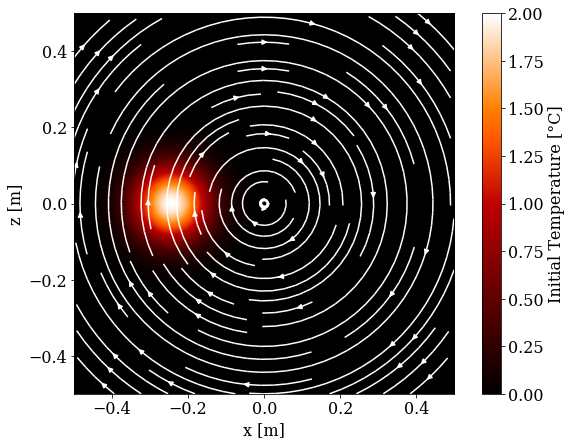

In [6]:
# Plot the initial temperature distribution and streamlines
pyplot.figure(figsize=(10.0, 7))

extent = [numpy.min(x), numpy.max(x),numpy.min(z), numpy.max(z)]
cmap = 'gist_heat'
im = pyplot.imshow(numpy.flipud(T0), extent=extent, interpolation='spline36', cmap=cmap)
stream = pyplot.streamplot(X,Z,Vx,Vz,color='w')

pyplot.xlabel('x [m]')
pyplot.ylabel('z [m]')
cbar = pyplot.colorbar(im)
cbar.set_label('Initial Temperature [°C]')

Looks correct, so finally we define the timestep `dt` and the number of time steps `nt` you want to advect the temperature field and run the `Adv_2D` code

In [7]:
# Set the time-step size
dt = 5e-1  # time-step size [s]
nt = 10   # number of time steps to compute

# Compute the temperature distribution after nt timesteps
T = Adv_2D(T0, nt, dt, dx, dz, Vx, Vz, -Lx, Lx, -Lz, Lz, x, z, X, Z)

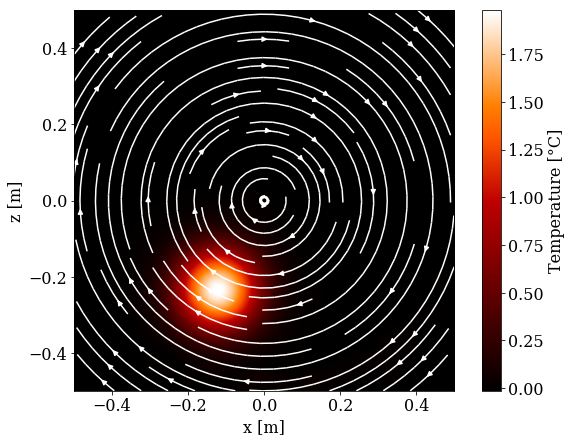

In [8]:
# Plot the temperature distribution and streamlines
pyplot.figure(figsize=(10.0, 7))

extent = [numpy.min(x), numpy.max(x),numpy.min(z), numpy.max(z)]
cmap = 'gist_heat'
im = pyplot.imshow(numpy.flipud(T), extent=extent, interpolation='spline36', cmap=cmap, aspect=1)
stream = pyplot.streamplot(X,Z,Vx,Vz,color='w')

pyplot.xlabel('x [m]')
pyplot.ylabel('z [m]')
cbar = pyplot.colorbar(im)
cbar.set_label('Temperature [°C]')

As we have seen in the [1D advection marker-in-cell notebook](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/04_Advection_1D/03_Numerical_Diffusion.ipynb) the marker-in-cell method shows no numerical diffusion. As you can see, this is also true for the 2D implementation. This becomes more obvious when visualizing the 2D advection in the following movie:

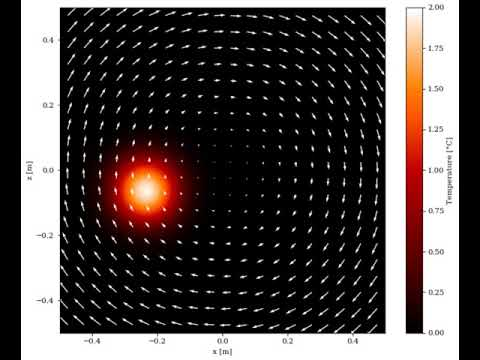

In [9]:
from IPython.display import YouTubeVideo
YouTubeVideo('tBd88w_tTF0')

Let's play around with another velocity field ...

## Temperature advection in a more complex velocity field

Because we want to use the marker-in-cell code to model mantle convection in the next lecture, let's study advection in the velocity field from the [Lorenz Equations](https://nbviewer.jupyter.org/github/daniel-koehn/Differential-equations-earth-system/blob/master/03_Lorenz_equations/01_LorenzEquations_intro.ipynb):

\begin{equation}
\begin{split}
V_x &= - 2 \pi\; sin(\pi x)\; cos(\pi z)\\
V_z &= 2 \pi\; cos(\pi x)\; sin(\pi z) 
\end{split}
\notag
\end{equation}

First, we define the modelling parameters ...

In [10]:
# Definition of modelling parameters
# ----------------------------------
Lx = 1.    # half-length of the model in x direction [m]
Lz = 1.    # half-height of the model in z direction [m]
nx = 41    # number of points in the x direction
nz = 41    # number of points in the z direction
dx = Lx / (nx - 1)  # grid spacing in the x direction
dz = Lz / (nz - 1)  # grid spacing in the z direction

# Define the locations along a gridline.
x = numpy.linspace(0, Lx, num=nx)
z = numpy.linspace(0, Lz, num=nz)

# Define the initial temperature distribution as Gaussian function
X, Z = numpy.meshgrid(x,z) # coordinates X,Z required to define T0

sigma = 0.1
amp = 2.
xshift = -0.25
zshift = -0.25

# initial temperature distribution
T0 = amp * numpy.exp(-((X + xshift)**2 + (Z+zshift)**2) / sigma**2.) 

# Define velocity field (Vx,Vz)
Vx = - 2. * numpy.pi * numpy.sin(numpy.pi*X) * numpy.cos(numpy.pi*Z)
Vz = 2. * numpy.pi * numpy.cos(numpy.pi*X) * numpy.sin(numpy.pi*Z)

... check if the initial temperature distribution and velocity field are correctly implemented ...

(0.0, 1.0)

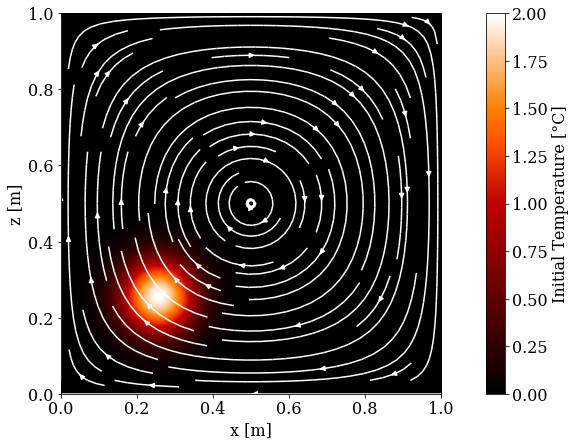

In [11]:
# Plot the initial temperature distribution and streamlines
pyplot.figure(figsize=(16., 7.))

extent = [numpy.min(x), numpy.max(x),numpy.min(z), numpy.max(z)]
cmap = 'gist_heat'
im = pyplot.imshow(numpy.flipud(T0), extent=extent, interpolation='spline36', cmap=cmap)
stream = pyplot.streamplot(X,Z,Vx,Vz,color='w')

pyplot.xlabel('x [m]')
pyplot.ylabel('z [m]')
cbar = pyplot.colorbar(im)
cbar.set_label('Initial Temperature [°C]')
pyplot.xlim(numpy.min(x), numpy.max(x))
pyplot.ylim(numpy.min(z), numpy.max(z))

... and run the advection code ...

In [12]:
# Set the time-step size
dt = 3e-2  # time-step size [s]
nt = 8    # number of time steps to compute

# Compute the temperature distribution after nt timesteps
T = Adv_2D(T0, nt, dt, dx, dz, Vx, Vz, 0, Lx, 0, Lz, x, z, X, Z)

(0.0, 1.0)

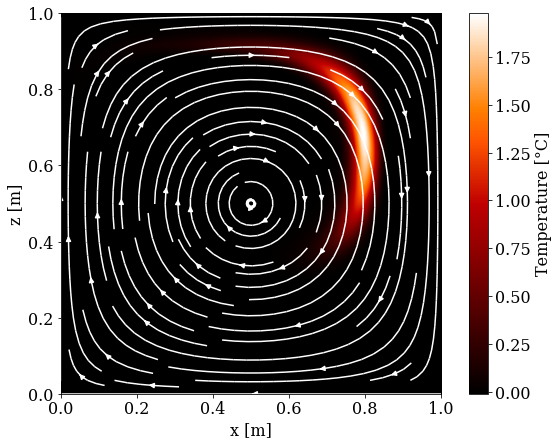

In [13]:
# Plot the temperature distribution and streamlines
pyplot.figure(figsize=(10.0, 7))

extent = [numpy.min(x), numpy.max(x),numpy.min(z), numpy.max(z)]
cmap = 'gist_heat'
im = pyplot.imshow(numpy.flipud(T), extent=extent, interpolation='spline36', cmap=cmap, aspect=1)
stream = pyplot.streamplot(X,Z,Vx,Vz,color='w')

pyplot.xlabel('x [m]')
pyplot.ylabel('z [m]')
cbar = pyplot.colorbar(im)
cbar.set_label('Temperature [°C]')
pyplot.xlim(numpy.min(x), numpy.max(x))
pyplot.ylim(numpy.min(z), numpy.max(z))

As you can see, the spherical 2°C temperature blob get 's quite distorted by the convective velocity field, the longer it is advected in the complex velocity field. Play around with the number of time steps `nt`. A movie of the more complex advection example can be found here:

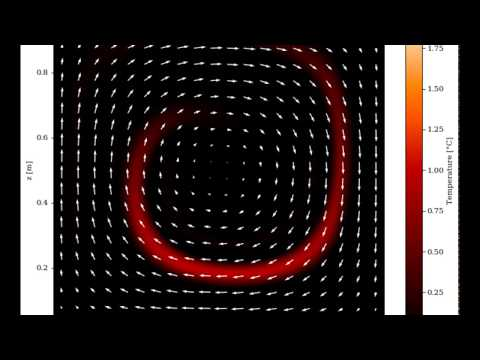

In [14]:
from IPython.display import YouTubeVideo
YouTubeVideo('GfLyEv9qYUU')

## What we learned:

* How to implement the 2D Marker-in-Cell code in Python

* Computed 2D advection of a Gaussian temperature distribution in a simple velocity field, where the shape is conserved 

* However, when using the velocity field from the Lorenz problem, the temperature distribution is significantly distorted over time.